<a href="https://colab.research.google.com/github/sarcasticvibes/Bengali-Character-classification-via-ResNet34/blob/master/Bengali_Character_Classification_via_ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bengali Character Classification via ResNet34
---

> I'm using **ResNet34** from `pretrained` module and fine tuning it for this classifivation task.

> In this task, we are given images of Bengali characters and we have to identify the *consonant diacritic*, *vowel diacritic* and the *grapheme root*.

> I'm making a single model which makes 3 predictions, one for each of the above categories thus adding 3 fully connected layers to the pretraines network.

## Downloading the required libraries and dataset from Kaggle
---

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarcasticvibes","key":"de2789990274bd1a6eaec3042ddf8be2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'bengaliai-cv19'

  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 3.03MB/s]
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 42.9MB/s]
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 81.0MB/s]
100% 991M/992M [00:15<00:00, 88.1MB/s]
100% 992M/992M [00:15<00:00, 69.0MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 141MB/s]
100% 993M/993M [00:15<00:00, 85.7MB/s]
100% 993M/993M [00:15<00:00, 65.8MB/s]
 99% 985M/991M [00:18<00:00, 53.9MB/s]
100% 991M/991M [00:18<00:00, 56.4MB/s]
  0% 0.00/4.75k [00:00<?, ?B/s]
100% 4.75k/4.75k [00:00<00:00, 5.05MB/s]
  0% 0.00/944 [00:00<?, ?B/s]
100% 944/944 [00:00<00:00, 982kB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 4.85MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 42.6MB/s]
  0% 0.00/16.8k [00:00<?, ?B/s]
100% 16.8k/16.8k [00:00<00:00, 14.1MB/s]
  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 178MB/s]
 99% 975M/986M [00:16<00:00, 63.6MB/s]
100% 9

In [ ]:
! mkdir training_set
! mkdir image_pickles

In [ ]:
! unzip train_image_data_0.parquet.zip -d training_set
! unzip train_image_data_1.parquet.zip -d training_set
! unzip train_image_data_2.parquet.zip -d training_set
! unzip train_image_data_3.parquet.zip -d training_set
! unzip train.csv.zip -d training_set

Archive:  train_image_data_0.parquet.zip
  inflating: training_set/train_image_data_0.parquet  
Archive:  train_image_data_1.parquet.zip
  inflating: training_set/train_image_data_1.parquet  
Archive:  train_image_data_2.parquet.zip
  inflating: training_set/train_image_data_2.parquet  
Archive:  train_image_data_3.parquet.zip
  inflating: training_set/train_image_data_3.parquet  
Archive:  train.csv.zip
  inflating: training_set/train.csv  


In [ ]:
!pip install iterative-stratification

In [ ]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=fa3555d90f5828465d7ee65a08ae26842dfac649f1fbace0514405704a8a0c1f
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [ ]:
import torch
import albumentations
from PIL import Image
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import joblib
import glob
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F
from IPython.display import clear_output

In [ ]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

## K-Fold Cross Validation setup
---
> I'm adding a new column to the dataset which contains the fold no. in which the item is used for validation.

In [ ]:
def create_KFold():
  dataframe = pd.read_csv('/content/training_set/train.csv')
  dataframe.loc[:,'kfold'] = -1
  dataframe.sample(frac = 1).reset_index(drop = True)
  X = dataframe.image_id.values
  y = dataframe[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
  mskf = MultilabelStratifiedKFold(n_splits=5)
  for fold, (train_, val_) in enumerate(mskf.split(X, y)):
    dataframe.loc[val_, 'kfold'] = fold
  print(dataframe.kfold.value_counts())
  dataframe.to_csv('/content/training_set/train_folds.csv')
  return dataframe

In [ ]:
dataframe = create_KFold()

4    40168
3    40168
2    40168
1    40168
0    40168
Name: kfold, dtype: int64


In [ ]:
dataframe.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,kfold
0,Train_0,15,9,5,ক্ট্রো,4
1,Train_1,159,0,0,হ,2
2,Train_2,22,3,5,খ্রী,1
3,Train_3,53,2,2,র্টি,2
4,Train_4,71,9,5,থ্রো,0


## Preprocessing the input images
---
> Changing the images from `*.parquet` input to `*.pkl` for faster processing during training with the help of `joblib`.

In [ ]:

def create_image_pickles():
  files = glob.glob('/content/training_set/train_image_data_*.parquet')
  for f in files:
    df = pd.read_parquet(f)
    image_ids = df.image_id.values
    df = df.drop('image_id', axis = 1)
    image_array = df.values
    for j, image_id in tqdm_notebook(enumerate(image_ids), total = len(image_ids)):
      joblib.dump(image_array[j,:], f"/content/image_pickles/{image_id}.pkl")

In [ ]:
create_image_pickles()

## Data Loader for the images
---

In [ ]:
class BengaliDatasetLoader:
  def __init__(self, folds, img_height, img_width, mean, std):
    df = pd.read_csv('/content/training_set/train_folds.csv')
    df = df[['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic','kfold']]
    df = df[df.kfold.isin(folds)].reset_index(drop = True)
    self.image_ids = df.image_id.values
    self.grapheme_root = df.grapheme_root.values
    self.vowel_diacritic = df.vowel_diacritic.values
    self.consonant_diacritic = df.consonant_diacritic.values
    if len(folds) == 1:
      self.aug = albumentations.Compose([
                                         albumentations.Resize(img_height, img_width, always_apply = True),
                                         albumentations.Normalize(mean = mean, std = std, always_apply = True),
      ])
    else:
      self.aug = albumentations.Compose([
                                         albumentations.Resize(img_height, img_width, always_apply = True),
                                         albumentations.ShiftScaleRotate(shift_limit=.0625, scale_limit=.1, rotate_limit=5,p=.8),
                                         albumentations.Normalize(mean = mean, std = std, always_apply = True),
      ])

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, item):
    image = joblib.load(f'/content/image_pickles/{self.image_ids[item]}.pkl')
    image = image.reshape(137,236)
    image = Image.fromarray(image).convert('RGB')
    image = self.aug(image = np.array(image))['image']
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    return {
        'image':torch.tensor(image, dtype=torch.float),
        'grapheme_root':torch.tensor(self.grapheme_root[item], dtype=torch.long),
        'vowel_diacritic':torch.tensor(self.vowel_diacritic[item], dtype=torch.long),
        'consonant_diacritic':torch.tensor(self.consonant_diacritic[item], dtype=torch.long)
    }

In [ ]:
dataset = BengaliDatasetLoader(folds=[0, 4], img_height=137, img_width=236, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
len(dataset)

80336

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(15)


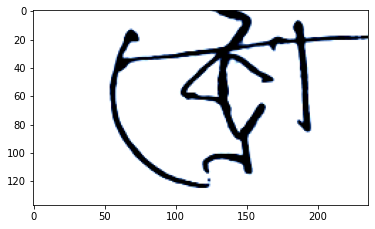

In [ ]:
idx = 0
img = dataset[idx]['image']
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2 ,0)))
print(dataset[idx]['grapheme_root'])

## Model
---

In [ ]:

class ResNet34(nn.Module):
  def __init__(self, pretrained):
    super(ResNet34, self).__init__()
    if pretrained:
      self.model = pretrainedmodels.__dict__['resnet34'](pretrained = 'imagenet')
    else:
      self.model = pretrainedmodels.__dict__['resnet34'](pretrained = None)
    self.l0 = nn.Linear(512, 168)
    self.l1 = nn.Linear(512, 11)
    self.l2 = nn.Linear(512, 7)
  
  def forward(self, x):
    bs,_,_,_ = x.shape
    x = self.model.features(x)
    x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
    l0 = self.l0(x)
    l1 = self.l1(x)
    l2 = self.l2(x)
    return l0, l1, l2

## Loss Function
---
> I'm using **Cross Entropy Loss**

In [ ]:
def loss_fn(outputs, targets):
  o1, o2, o3 = outputs
  t1, t2, t3 = targets
  l1 = nn.CrossEntropyLoss()(o1, t1)
  l2 = nn.CrossEntropyLoss()(o2, t2)
  l3 = nn.CrossEntropyLoss()(o3, t3)
  return (l1 + l2 + l3)/ 3

## Training Functions
---

In [ ]:
def train_helper(model, dataset, dataloader, optimizer):
  model.to(device)
  model.train()
  for bi, d in tqdm_notebook(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
    grapheme_root = d['grapheme_root']
    vowel_diacritic = d['vowel_diacritic']
    consonant_diacritic = d['consonant_diacritic']
    image = d['image']
    
    image = image.to(device, dtype=torch.float)
    grapheme_root = grapheme_root.to(device, dtype=torch.long)
    vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
    consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

    optimizer.zero_grad()

    outputs = model(image)
    targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

    loss = loss_fn(outputs, targets)
    
    loss.backward()
    optimizer.step()

In [ ]:
def train_fn(model, device, img_height, img_width, epochs, batch_size_train, batch_size_val, mean, std, training_folds, validation_folds):
  model.to(device)
  training_dataset = BengaliDatasetLoader(folds=training_folds, 
                                          img_height=img_height, 
                                          img_width=img_width, 
                                          mean=mean, 
                                          std=std)
  train_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                             batch_size=batch_size_train, 
                                             shuffle=True,
                                             num_workers=4)
  
  validation_dataset = BengaliDatasetLoader(folds=validation_folds, 
                                          img_height=img_height, 
                                          img_width=img_width, 
                                          mean=mean, 
                                          std=std)
  validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                             batch_size=batch_size_val, 
                                             shuffle=False,
                                             num_workers=4)
  
  optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode='min', patience=5, factor=.3)

  for epoch in range(epochs):
    clear_output(wait=True)
    print(f'Epoch:{epoch+1}/{epochs}')
    print('Training...')
    train_helper(model, training_dataset, train_loader, optim)
    print('Validating...')
    val_score = eval_helper(model, validation_dataset, validation_loader)
    scheduler.step(val_score)
    if(epoch % 10 == 0):
      torch.save(model.state_dict(), f'/content/drive/My Drive/Bengali_ai_outputs/ResNet34_fold{validation_folds[0]}_epoch{epoch}.bin')
  torch.save(model.state_dict(), f'/content/drive/My Drive/Bengali_ai_outputs/ResNet34_fold{validation_folds[0]}.bin')
  return model

## Evaluation function
---

In [ ]:
def eval_helper(model, dataset, dataloader):
  model.to(device)
  model.eval()

  final_loss = 0
  counter = 0

  for bi, d in tqdm_notebook(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
    
    counter += 1
    
    grapheme_root = d['grapheme_root']
    vowel_diacritic = d['vowel_diacritic']
    consonant_diacritic = d['consonant_diacritic']
    image = d['image']
    
    image = image.to(device, dtype=torch.float)
    grapheme_root = grapheme_root.to(device, dtype=torch.long)
    vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
    consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

    outputs = model(image)
    targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

    loss = loss_fn(outputs, targets)
    final_loss += loss.item()
  return final_loss / counter

## Training Configuration
---

In [ ]:

device ='cuda'
model = ResNet34(True)
Training_Folds_CSV = '/content/training_set/train_folds.csv'

Img_Height = 137 #Given constant values for the images
Img_Width = 236

Epochs = 32
BatchSize_Train = 256
BatchSize_Test = 256

Mean = (0.485, 0.456, 0.406)    #Standard Values for the ResNet model
Std = (0.229, 0.224, 0.225)


Training_Folds = (0, 1, 2, 3)
Validation_Folds = (4,)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Training
---

In [ ]:
model = train_fn(model, device, Img_Height, Img_Width, Epochs, BatchSize_Train, BatchSize_Test, Mean, Std, Training_Folds, Validation_Folds)

Epoch:32/32
Training...



Validating...


In [ ]:
model = torch.load('ResNet50_fold4.bin')

**Note** : I still have to add inference and evaluation. Since the dataset is fairly large training it caused me to use all my gpu quota on cloab. Once that is available again, I'll do inference with just one fold due to the time and resource constraints